In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import time

In [2]:
def gerschgorin_circles(matrix):
    if matrix.shape[0] != matrix.shape[1]:
        raise ValueError("The input must be a square matrix.")

    n = matrix.shape[0]
    circles = []

    for i in range(n):
        center = matrix[i, i]
        radius = sum(abs(matrix[i, j]) for j in range(n) if j != i)
        circles.append((center.real, center.imag, radius))

    return circles

In [3]:
def circles_overlap(c1, c2):
    # Check if two circles overlap
    dx = c1[0] - c2[0]
    dy = c1[1] - c2[1]
    distance = np.hypot(dx, dy)
    return distance <= (c1[2] + c2[2])

In [4]:
def gerschgorin_stability(circles, system_type):
    # Cluster circles into unions of overlapping circles
    unions = []
    for circle in circles:
        added = False
        for union in unions:
            if any(circles_overlap(circle, existing_circle) for existing_circle in union):
                union.append(circle)
                added = True
                break
        if not added:
            unions.append([circle])
    
    stable = True
    inconclusive = False
    
    for union in unions:
        # Compute union bounds
        if system_type == "continuous":
            leftmost = min(c[0] - c[2] for c in union)
            rightmost = max(c[0] + c[2] for c in union)
            if leftmost > 0:
                return False, False
            if leftmost <= 0 <= rightmost:
                inconclusive = True
        elif system_type == "discrete":
            min_norm = max(0, min(np.hypot(c[0], c[1]) - c[2] for c in union))
            max_norm = max(np.hypot(c[0], c[1]) + c[2] for c in union)
            if min_norm > 1:
                return False, False 
            if min_norm <= 1 <= max_norm:
                inconclusive = True
        else:
            raise ValueError("System must be 'continuous' or 'discrete'.")
    
    return stable, inconclusive

In [5]:
def plot_gerschgorin_circles(matrix, system_type):
    circles = gerschgorin_circles(matrix)
    stable, inconclusive = gerschgorin_stability(circles, system_type)

    fig, ax = plt.subplots(figsize=(8, 8))

    for center_real, center_imag, radius in circles:
        circle = plt.Circle((center_real, center_imag), radius, color='b', fill=False, linestyle='--', linewidth=1.5)
        ax.add_artist(circle)
        ax.plot(center_real, center_imag, 'ro')  # Center of the circle

    # Stability limit
    if system_type == "continuous":
        ax.axvline(0, color='red', linestyle='-', linewidth=1.5, label="Stability border (Re=0)")
    elif system_type == "discrete":
        unit_circle = plt.Circle((0, 0), 1, color='red', fill=False, linestyle='-', linewidth=1.5, label="Unitary circle")
        ax.add_artist(unit_circle)

    # Stability check
    if not inconclusive:
        stability_msg = "Stable" if stable else "Unstable"
        print(f"The system is {stability_msg} based on Gerschgorin circles.")
    else:
        print("Gerschgorin is inconclusive. Computing eigenvalues...")

        # Calcolo degli autovalori
        eigenvalues = np.linalg.eigvals(matrix)

        # Determina l'autovalore critico
        if system_type == "continuous":
            critical_eigenvalue = max(eigenvalues, key=lambda ev: ev.real)  # Maggiore parte reale
            stability_criterion = critical_eigenvalue.real >= 0
        elif system_type == "discrete":
            critical_eigenvalue = max(eigenvalues, key=lambda ev: abs(ev))  # Modulo massimo
            stability_criterion = abs(critical_eigenvalue) >= 1

        # Plotta l'autovalore critico
        ax.plot(critical_eigenvalue.real, critical_eigenvalue.imag, 'go', markersize=10, label="Critical eigenvalue")

        print(f"Critical eigenvalue: {critical_eigenvalue}")

        if stability_criterion:
            print("Warning: The system might be unstable based on eigenvalues.")
        else:
            print("The system is stable based on eigenvalues.")

    ax.axhline(0, color='black', linewidth=0.8)
    ax.axvline(0, color='black', linewidth=0.8)
    ax.set_aspect('equal', adjustable='datalim')
    ax.grid(True, linestyle='--', alpha=0.6)

    # Plot limits
    all_x = [c[0] for c in circles]
    all_y = [c[1] for c in circles]
    max_radius = max(c[2] for c in circles)
    ax.set_xlim(min(all_x) - max_radius - 1, max(all_x) + max_radius + 1)
    ax.set_ylim(min(all_y) - max_radius - 1, max(all_y) + max_radius + 1)

    plt.xlabel('Real')
    plt.ylabel('Imaginary')
    plt.title(f'Gerschgorin Circles & Stability Analysis ({system_type.capitalize()})')
    plt.legend()
    plt.savefig("plot.png", bbox_inches="tight")
    plt.show()



--- Continuous System ---
The system is Unstable based on Gerschgorin circles.


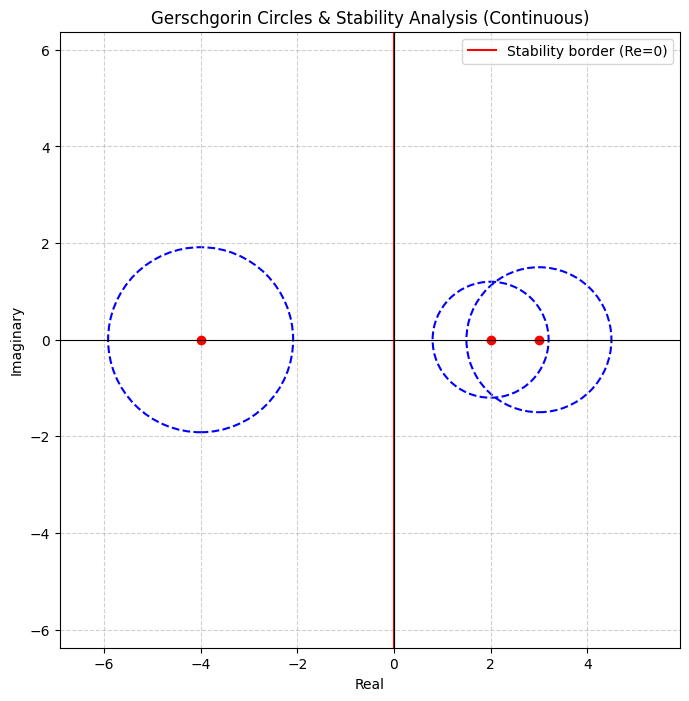


--- Discrete System ---
The system is Unstable based on Gerschgorin circles.


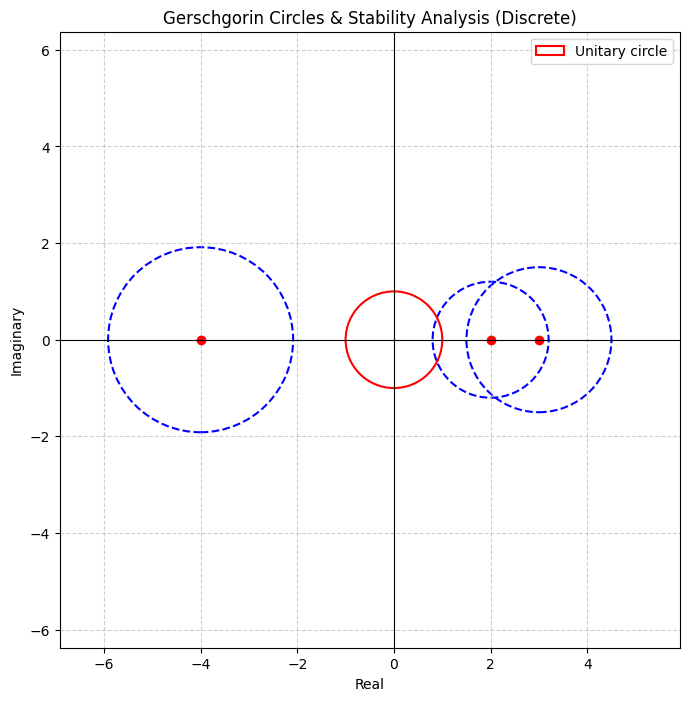

In [6]:
# Example Matrix
A = np.array([[-4, 1+1j, 0.5],
              [0.5, 3, 1],
              [1j, 0.2, 2]])


print("\n--- Continuous System ---")
plot_gerschgorin_circles(A, system_type="continuous")

print("\n--- Discrete System ---")
plot_gerschgorin_circles(A, system_type="discrete")


--- Continuous System ---
Gerschgorin is inconclusive. Computing eigenvalues...
Critical eigenvalue: (-0.5+1j)
The system is stable based on eigenvalues.


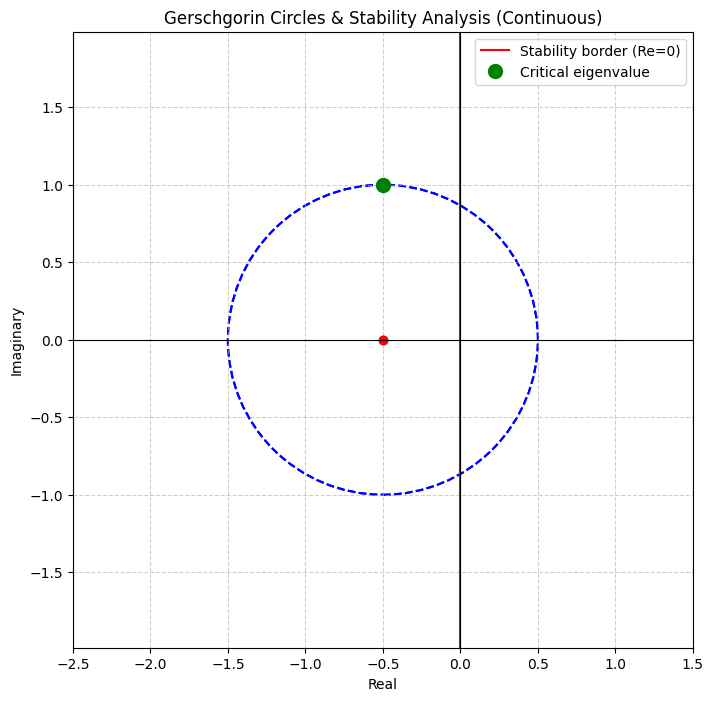


--- Discrete System ---
Gerschgorin is inconclusive. Computing eigenvalues...
Critical eigenvalue: (-0.5+1j)


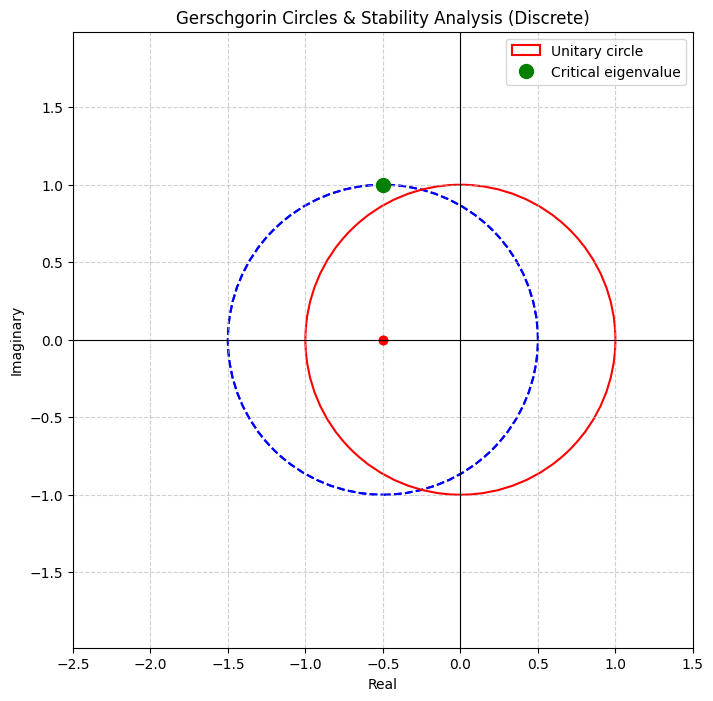

In [7]:
# 1. Hopf Bifurcation Normal Form
def jacobian_hopf(mu=-0.5, omega=1):
    return np.array([
        [mu, -omega],
        [omega, mu]
    ])

J_h = jacobian_hopf()
print("\n--- Continuous System ---")
plot_gerschgorin_circles(J_h, system_type="continuous")

print("\n--- Discrete System ---")
plot_gerschgorin_circles(J_h, system_type="discrete")


--- Continuous System ---
Gerschgorin is inconclusive. Computing eigenvalues...
Critical eigenvalue: 1.89996


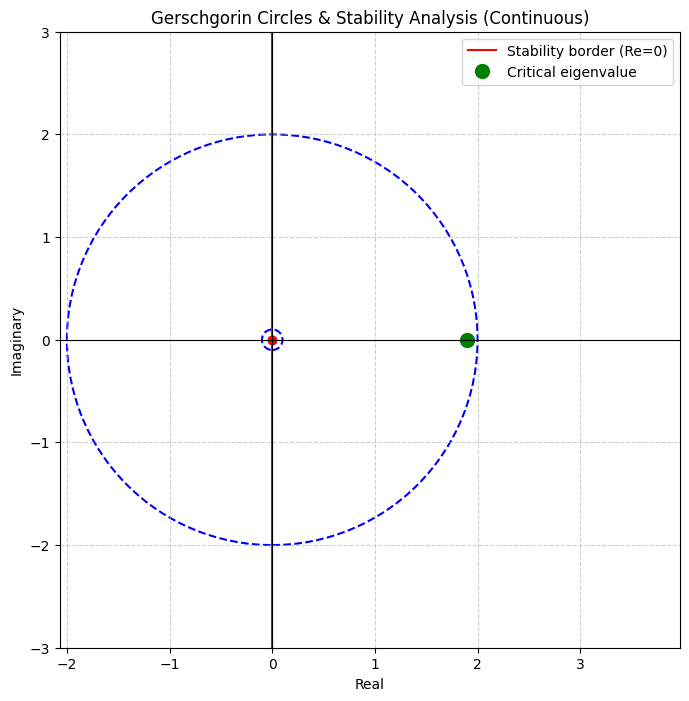


--- Discrete System ---
Gerschgorin is inconclusive. Computing eigenvalues...
Critical eigenvalue: 1.89996


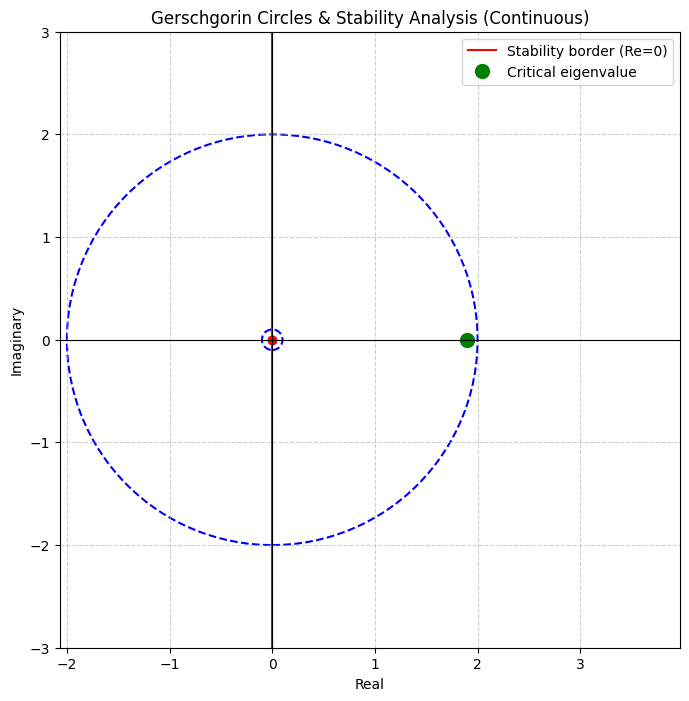

In [8]:
# 2. SIR Model (Disease-Free Equilibrium)
def jacobian_sir(beta=2, gamma=0.1, mu=0.00004):
    S0 = 1.0
    return np.array([
        [-mu, -beta*S0, 0],
        [0, beta*S0 - (gamma + mu), 0],
        [0, gamma, -mu]
    ])

J_s = jacobian_sir()

print("\n--- Continuous System ---")
plot_gerschgorin_circles(J_s, system_type="continuous")

print("\n--- Discrete System ---")
plot_gerschgorin_circles(J_s, system_type="continuous")


--- Continuous System ---
Gerschgorin is inconclusive. Computing eigenvalues...
Critical eigenvalue: 1.1547005383792517j


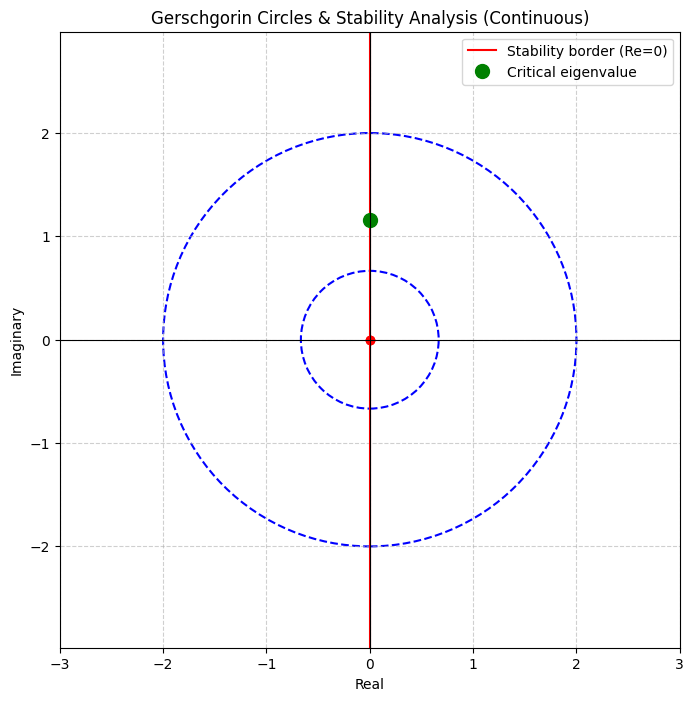


--- Discrete System ---
Gerschgorin is inconclusive. Computing eigenvalues...
Critical eigenvalue: 1.1547005383792517j


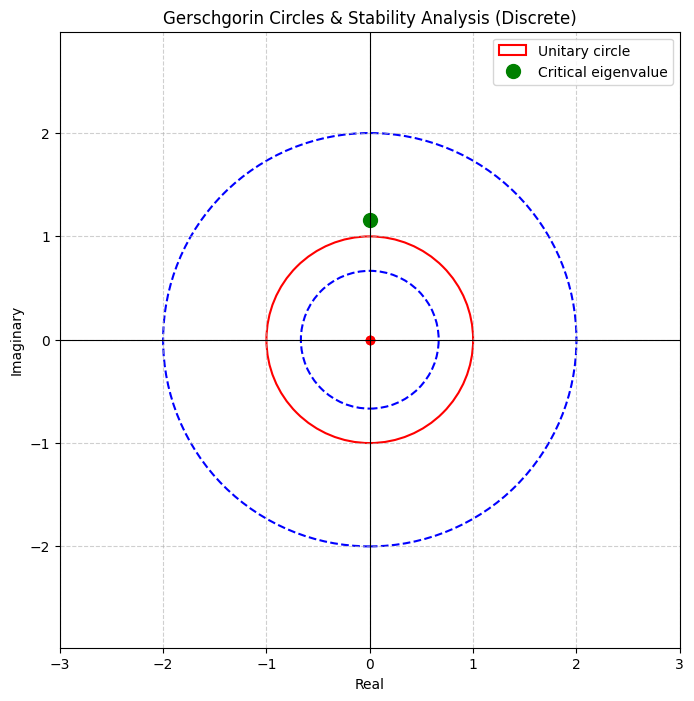

In [9]:
# 3. Lotka-Volterra (at coexistence equilibrium)
def jacobian_lotka_volterra(alpha=2, beta=0.5, delta=0.3, gamma=0.1):
    # Equilibrium: x* = gamma/delta, y* = alpha/beta
    return np.array([
        [0, -alpha*(gamma/delta)],
        [beta*(alpha/beta), 0]
    ])

J_lv = jacobian_lotka_volterra()
print("\n--- Continuous System ---")
plot_gerschgorin_circles(J_lv, system_type="continuous")

print("\n--- Discrete System ---")
plot_gerschgorin_circles(J_lv, system_type="discrete")

In [10]:
def power_method(A, tol=1e-12, max_iter=10000, seed=None):
    n = A.shape[0]

    # Initialize the random seed for reproducibility
    if seed is not None:
        np.random.seed(seed)

    num_random_starts = 5
    v_final = np.zeros(n)
    
    for _ in range(num_random_starts):
        v = np.random.rand(n)
        v_final += v

    # Average the random vectors
    v_final /= num_random_starts  
    v_final /= np.linalg.norm(v_final)

    lambda_approx = None 

    for _ in range(max_iter):
        w = np.dot(A, v_final)
        lambda_new = np.dot(v_final.T, w)
        v_new = w / np.linalg.norm(w)

        if lambda_approx is None:
            lambda_approx = lambda_new
        else:
            lambda_approx = lambda_new

        if np.linalg.norm(v_new - v_final) < tol:
            break
        v_final = v_new

    return lambda_approx

In [11]:
def lanczos(A, k=100, tol=1e-12):
    n = A.shape[0]
    Q = np.zeros((n, k), dtype=np.float64) 
    alpha = np.zeros(k, dtype=np.float64)
    beta = np.zeros(k, dtype=np.float64)
    
    num_random_starts = 5
    q = np.zeros(n)
    for _ in range(num_random_starts):
        v = np.random.rand(n)
        v /= np.linalg.norm(v)
        q += v
    q /= num_random_starts
    q /= np.linalg.norm(q)
    
    Q[:, 0] = q
    w = A.dot(Q[:, 0])
    alpha[0] = np.dot(Q[:, 0], w)
    r = w - alpha[0] * Q[:, 0]
    beta[0] = np.linalg.norm(r)
    
    m = k 
    for j in range(1, k):
        if beta[j-1] < tol:
            m = j
            break
        Q[:, j] = r / beta[j-1]
        w = A.dot(Q[:, j])
        alpha[j] = np.dot(Q[:, j], w)
        r = w - alpha[j] * Q[:, j] - beta[j-1] * Q[:, j-1]
        beta[j] = np.linalg.norm(r)
    
    # Adjust m if loop broke early
    if beta[j] < tol and j < k-1:
        m = j + 1
    
    # Construct T of size m x m
    T = np.diag(alpha[:m]) + np.diag(beta[:m-1], 1) + np.diag(beta[:m-1], -1)
    eigenvalues = np.linalg.eigvalsh(T)
    return np.max(eigenvalues)

In [12]:
# Function that compares the three methods

def compare_methods(A):
    
    start_time = time.time()
    print(power_method(A))
    end_time = time.time()
    print(f"Power_method: {end_time - start_time:.4f} seconds")
    
    start_time = time.time()
    print(np.max(np.linalg.eigvals(A)))
    end_time = time.time()
    print(f"Np.linalg.eigvals: {end_time - start_time:.4f} seconds")
    
    start_time = time.time()
    print(lanczos(A))
    end_time = time.time()
    print(f"Lanczos: {end_time - start_time:.4f} seconds")


In [13]:
# Matrix dimension
n = 10000

# Density of the matrix 
density = 0.1 

sparse_matrix = sp.random(n, n, density=density, format='csr', dtype=np.float64)
sparse_matrix = (sparse_matrix + sparse_matrix.T) / 2

compare_methods(sparse_matrix.toarray())

500.20205499140957
Power_method: 0.1396 seconds
500.2020549914098
Np.linalg.eigvals: 369.7870 seconds
500.20205499142435
Lanczos: 1.6530 seconds
